In [1]:
from setup_env import setup_environment

setup_environment()

In [2]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
)
import matplotlib.pyplot as plt

In [3]:
file = "20260124_171024_20.csv"
df = pd.read_csv(f"data/training/judge/{file}")

df.sample(3)

,entropy_mean,entropy_std,p_collapsed,p_uncollapsed,p_walkable_collapsed,p_entropy_1,p_entropy_2,p_entropy_3,entropy_gradient_mean,entropy_gradient_max,should_continue
11134,9.462222,11.479049,7.333333,7.666667,0.490909,0.000000,0.000000,0.533333,2.780952,21.0,1
21462,13.017778,12.408228,5.866667,9.066667,0.522727,0.066667,0.066667,0.133333,1.919048,24.0,1
1757,2.008889,5.752674,12.200000,2.800000,0.338798,0.000000,0.066667,0.666667,1.059524,25.0,1


In [4]:
df["should_continue"].value_counts()

should_continue
1    27223
0     1862
Name: count, dtype: int64

In [5]:
X = df.drop(columns=["should_continue"])
y = df["should_continue"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [6]:
cw0 = (y_train == 1).sum() / (y_train == 0).sum()
cw1 = 1.0
class_weights = [cw0, cw1]

In [7]:
clf = CatBoostClassifier(
    iterations=300,
    learning_rate=0.07,
    depth=6,
    eval_metric="F1",
    class_weights=class_weights,
    verbose=50,
    random_seed=42,
)
clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

0:	learn: 0.6451554	test: 0.6413683	best: 0.6413683 (0)	total: 61.7ms	remaining: 18.4s
50:	learn: 0.7664981	test: 0.7543746	best: 0.7543746 (50)	total: 220ms	remaining: 1.07s
100:	learn: 0.8268944	test: 0.7906152	best: 0.7906152 (100)	total: 384ms	remaining: 756ms
150:	learn: 0.8627468	test: 0.8145275	best: 0.8145275 (150)	total: 545ms	remaining: 537ms
200:	learn: 0.8890639	test: 0.8348706	best: 0.8362176 (191)	total: 697ms	remaining: 343ms
250:	learn: 0.9022832	test: 0.8475059	best: 0.8488015 (248)	total: 907ms	remaining: 177ms
299:	learn: 0.9157843	test: 0.8570225	best: 0.8579876 (292)	total: 1.09s	remaining: 0us

bestTest = 0.857987557
bestIteration = 292

Shrink model to first 293 iterations.
              precision    recall  f1-score   support

           0      0.270     0.887     0.414       372
           1      0.991     0.836     0.907      5445

    accuracy                          0.839      5817
   macro avg      0.630     0.862     0.660      5817
weighted avg      0.94

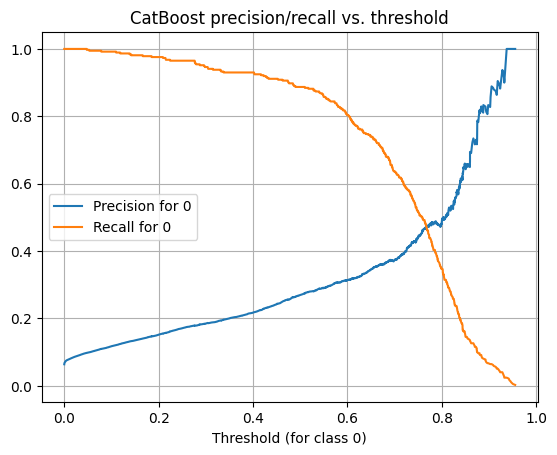

In [8]:
y_proba = clf.predict_proba(X_test)[:, 0]
prec, rec, thresh = precision_recall_curve(y_test == 0, y_proba)
plt.plot(thresh, prec[:-1], label="Precision for 0")
plt.plot(thresh, rec[:-1], label="Recall for 0")
plt.xlabel("Threshold (for class 0)")
plt.title("CatBoost precision/recall vs. threshold")
plt.legend()
plt.grid()
plt.show()